In [48]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
import matplotlib.pyplot as plt
import seaborn as sns
from TwitterDataAnalysis import processing
from nrclex import NRCLex
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
import nltk
nltk.download('punkt')
import gensim
import spacy
sp = spacy.load('en_core_web_sm')
from gensim.models import ldamodel

%load_ext autoreload
%autoreload 2
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tabithasugumar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
paris = pd.read_csv("Data/full_paris.csv")
gnd = pd.read_csv("Data/full_gnd.csv")

#### Exploratory Data Analysis

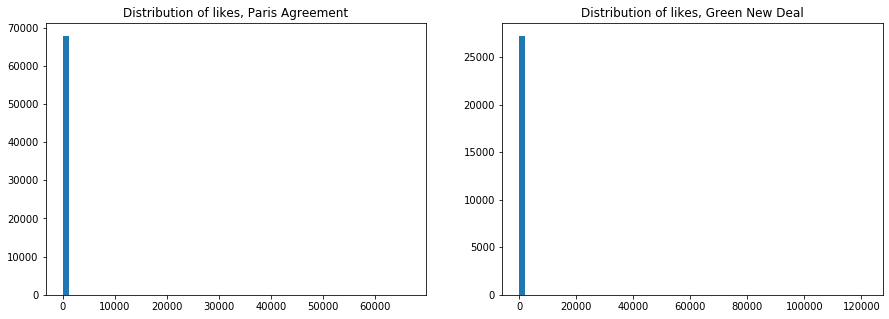

In [50]:
fig,ax = plt.subplots(1,2,figsize = (15,5))
  
ax[0].hist(paris["favorite_count"], bins = 60)
ax[0].set_title("Distribution of likes, Paris Agreement")
ax[1].hist(gnd["favorite_count"], bins = 60)
ax[1].set_title("Distribution of likes, Green New Deal")
plt.show()

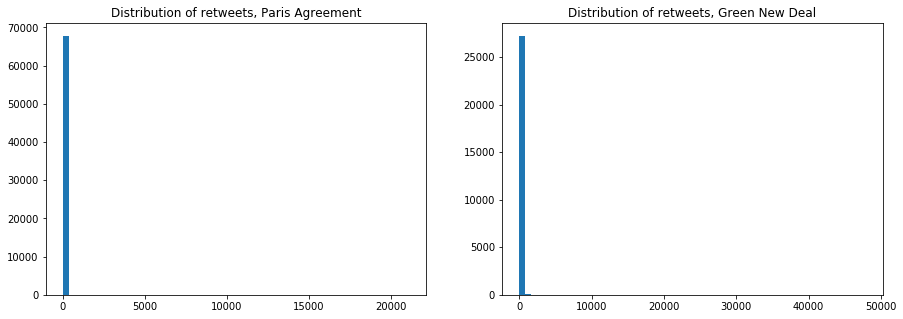

In [51]:
fig,ax = plt.subplots(1,2,figsize = (15,5))
  
ax[0].hist(paris["retweet_count"], bins = 60)
ax[0].set_title("Distribution of retweets, Paris Agreement")
ax[1].hist(gnd["retweet_count"], bins = 60)
ax[1].set_title("Distribution of retweets, Green New Deal")
plt.show()

In [52]:
display(paris[paris["favorite_count"] > 2000])

,Unnamed: 0,id_str,created_at,full_text,retweet_count,favorite_count,user_id,screen_name,name,location
5130,5130,1039221205348147200,Mon Sep 10 18:36:57 +0000 2018,#sb100 and this executive order put california...,1489,5570,19418459,JerryBrownGov,Jerry Brown,California
12328,12328,1051861765288411136,Mon Oct 15 15:46:02 +0000 2018,chinese premier li keqiang said china would li...,168,2058,487118986,XHNews,China Xinhua News,"Headquartered in Beijing, PRC"
17305,17305,1014703802048446465,Thu Jul 05 02:53:33 +0000 2018,the climate change denying trump administratio...,7341,16209,3333055535,EricHolder,Eric Holder,NaN
19176,19176,1018100807206670336,Sat Jul 14 11:52:02 +0000 2018,we've hit @realdonaldtrump where it hurts - at...,2162,3559,4012161,GreenpeaceUK,Greenpeace UK,UK
24470,24470,1028420207348465669,Sat Aug 11 23:17:39 +0000 2018,an excellent piece by @latstevelopez. trump co...,3986,12904,251918778,MichaelAvenatti,Michael Avenatti,LA / NY
27412,27412,1068990220505399298,Sat Dec 01 22:08:24 +0000 2018,only 19 of the #g20 countries agreed to suppor...,552,2213,499154896,alexbruesewitz,Alex Bruesewitz,"Washington, DC/Palm Beach, FL"
27600,27600,1069056847531950080,Sun Dec 02 02:33:09 +0000 2018,thread: paris is in flames with roits &amp; bl...,1550,2813,762389795037294592,TheRightMelissa,Melissa Tate,NaN
27906,27906,1069195699680616448,Sun Dec 02 11:44:54 +0000 2018,worst riots in paris for 50 years. 412 arreste...,8224,19462,18643437,PrisonPlanet,Paul Joseph Watson,London
28220,28220,1069278755041001472,Sun Dec 02 17:14:56 +0000 2018,🚨the #parisprotest ain’t no small thing! franc...,2337,2851,375434404,RealMAGASteve,𝕄𝔸𝔾𝔸🇺🇸🅟🅐🅣🅡🅘🅞🅣🇺🇸𝕊𝕋𝔼𝕍𝔼™️,Please 🚫Trains
31715,31715,1070333779422707713,Wed Dec 05 15:07:13 +0000 2018,delivering on the paris agreement requires act...,1546,6180,133880286,LeoDiCaprio,Leonardo DiCaprio,"Los Angeles, CA"


#### Tweeters

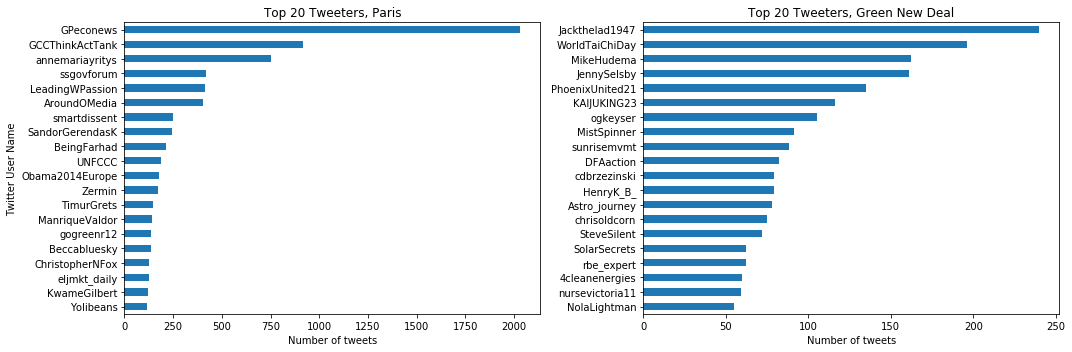

In [53]:
paris_users = paris.screen_name.value_counts().sort_values()
gnd_users = gnd.screen_name.value_counts().sort_values()

fig, ax = plt.subplots(1,2, figsize=(15,5))
paris_users[-20:].plot.barh(ax = ax[0])
ax[0].set_title("Top 20 Tweeters, Paris")
ax[0].set_ylabel("Twitter User Name")
ax[0].set_xlabel("Number of tweets")

gnd_users[-20:].plot.barh(ax = ax[1])
ax[1].set_title("Top 20 Tweeters, Green New Deal")
#ax[1].set_ylabel("Twitter User Name")
ax[1].set_xlabel("Number of tweets")
plt.tight_layout()
plt.show()

#### Hashtags

In [54]:
processing.get_cols(paris)
processing.get_cols(gnd)

In [55]:
hashtags_paris = processing.get_entities(paris)
hashtags_gnd = processing.get_entities(gnd)

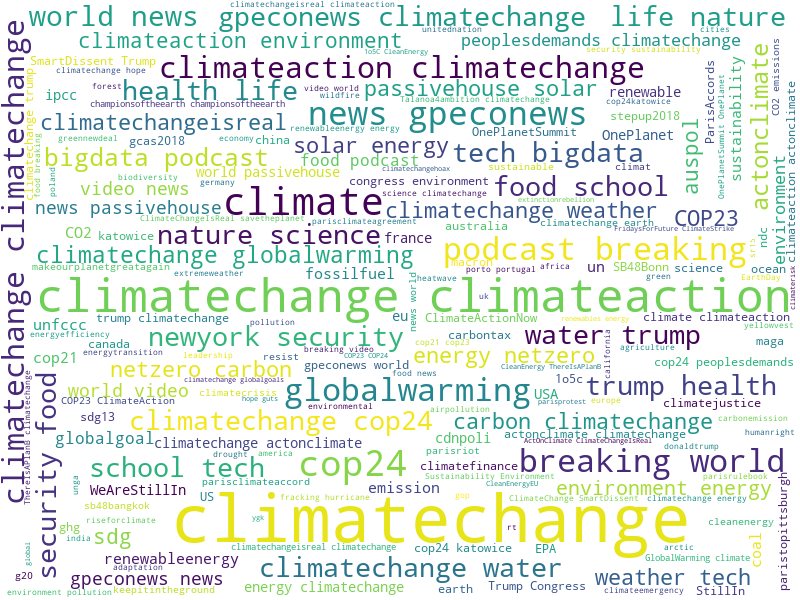

In [56]:
hashtags_cloud = WordCloud(background_color = "white", stopwords = ["ParisAgreement", "ParisAccord", "Paris"], width = 800, height = 600)
hashtags_cloud.generate(" ".join(hashtags_paris))
hashtags_cloud.to_image()

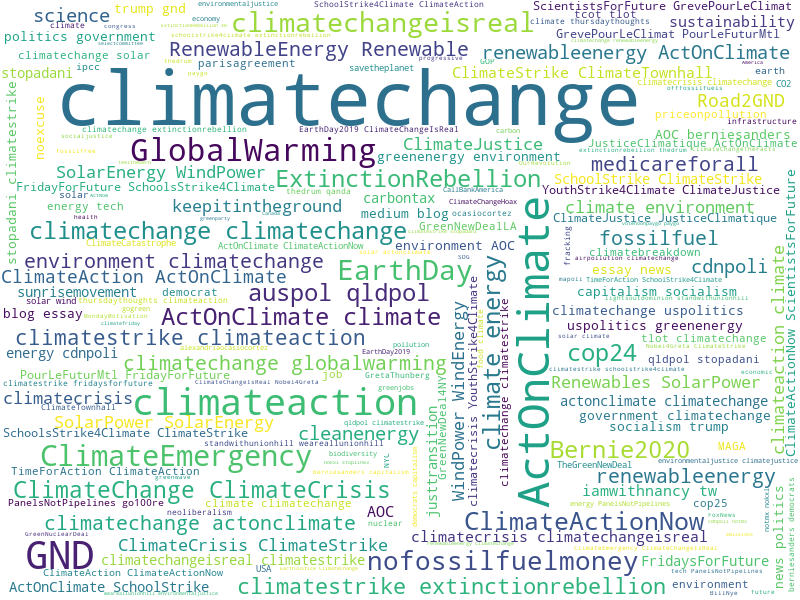

In [57]:
hashtags_cloud = WordCloud(background_color = "white", stopwords = ["GreenNewDeal", "NewDeal", "Green", "New", "Deal"], width = 800, height = 600)
hashtags_cloud.generate(" ".join(hashtags_gnd))
hashtags_cloud.to_image()

#### Mentions

In [58]:
mentions_paris = processing.get_entities(paris, "mentions")
mentions_gnd = processing.get_entities(gnd, "mentions")

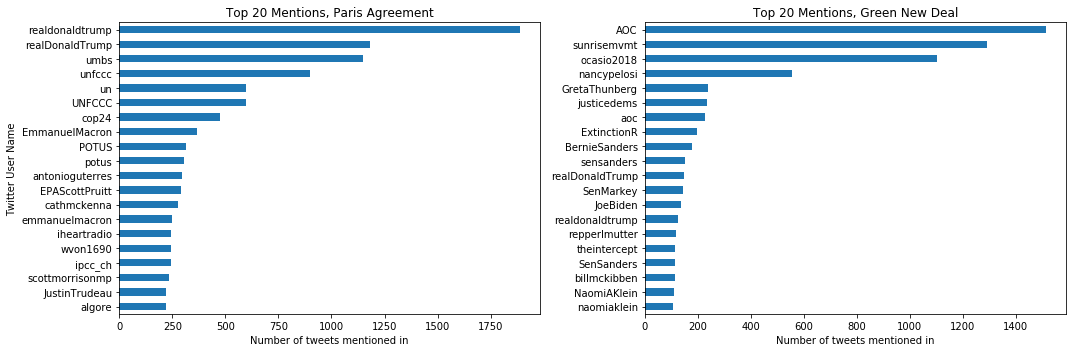

In [59]:
unique_mentions_paris = np.unique(mentions_paris, return_counts = True)
unique_mentions_gnd = np.unique(mentions_gnd, return_counts = True)

m_paris = pd.Series(unique_mentions_paris[1], index = unique_mentions_paris[0])
m_gnd = pd.Series(unique_mentions_gnd[1], index = unique_mentions_gnd[0])

fig, ax = plt.subplots(1,2, figsize=(15,5))


m_paris.sort_values()[-20:].plot.barh(ax = ax[0])
ax[0].set_title("Top 20 Mentions, Paris Agreement")
ax[0].set_ylabel("Twitter User Name")
ax[0].set_xlabel("Number of tweets mentioned in")
   
m_gnd.sort_values()[-20:].plot.barh(ax = ax[1])
ax[1].set_title("Top 20 Mentions, Green New Deal")
ax[1].set_xlabel("Number of tweets mentioned in")
plt.tight_layout()
plt.show()

#### Tweets

In [60]:
paris_tweets = paris["full_text"].apply(processing.clean_text_lda)
gnd_tweets = gnd["full_text"].apply(processing.clean_text_lda)

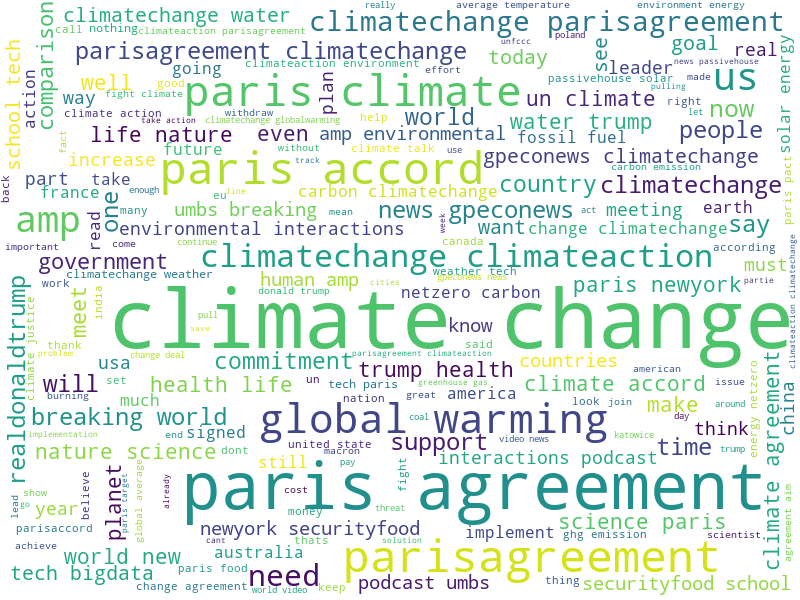

In [61]:
tweets_cloud = WordCloud(background_color = "white", stopwords = STOPWORDS, width = 800, height = 600)
tweets_cloud.generate(" ".join(list(paris_tweets)))
tweets_cloud.to_image()

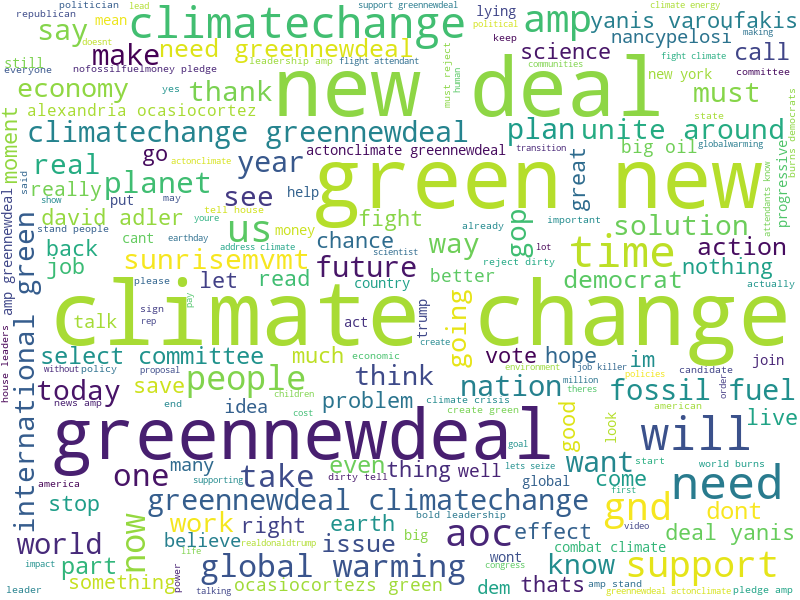

In [62]:
tweets_cloud = WordCloud(background_color = "white", stopwords = STOPWORDS, width = 800, height = 600)
tweets_cloud.generate(" ".join(list(gnd_tweets)))
tweets_cloud.to_image()

#### LDA

In [ ]:
paris_stop_words = []
gnd_stop_words = []

In [5]:
all_stopwords = sp.Defaults.stop_words

set

In [20]:
count_vectorizer = CountVectorizer(stop_words = all_stopwords)
tweet_data = count_vectorizer.fit_transform(list(tweets))

In [24]:
number_topics = 4
number_words = 10
lda = LDA(n_components = number_topics, n_jobs = -1)
lda.fit(tweet_data)

LatentDirichletAllocation(n_components=4, n_jobs=-1)

In [115]:
processing.print_top_words(lda, count_vectorizer.get_feature_names(), 20)

Topic #0: parisagreement climate climatechange amp climateaction world years event december energy unga global action anniversary parisaccord rejoin uk change coal joebiden
Topic #1: fossil funding overseas parisagreement climatechange stop fuels infrastructure uk billion govt prime fuel minister ask spent parisaccord joebiden rejoin democracy
Topic #2: parisagreement climate amp goals climatechange climateaction countries level china emissions target ndcs sea ice antarctic parisaccord sustainable met updated paris
Topic #3: parisagreement amp climate climateaction emissions carbon need new countries targets climatechange global goals china meet today plan climateweeknyc biden event


In [26]:
pyLDAvis.sklearn.prepare(lda, tweet_data, count_vectorizer)

/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.064008 -0.107108       1        1  31.186227
3      0.087253  0.009586       2        1  28.907018
1     -0.216618  0.001256       3        1  23.395153
2      0.065356  0.096266       4        1  16.511601, topic_info=     Category        Freq         Term       Total  loglift  logprob
1686  Default  142.000000       fossil  142.000000  30.0000  30.0000
1742  Default  140.000000      funding  140.000000  29.0000  29.0000
3084  Default  134.000000     overseas  134.000000  28.0000  28.0000
4070  Default   79.000000         stop   79.000000  27.0000  27.0000
1729  Default   74.000000        fuels   74.000000  26.0000  26.0000
...       ...         ...          ...         ...      ...      ...
4133   Topic4    7.167888      support   26.192106   0.5053  -5.9227
3121   Topic4    9.271862  parisaccord   81.898175  -0.3774  -5.6654
2901   Topic4    7.239842         need   42.092764   0.0408  -5.9127
4705   Topic4    7.235226        world   56.439525  -0.2531  -5.9134
4190   Topic4    6.033696      targets   34.269718   0.0642  -6.0950

[273 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
17        2  0.741000  accelerate
17        3  0.211714  accelerate
42        1  0.561382      action
42        2  0.280691      action
42        4  0.153104      action
...     ...       ...         ...
4710      2  0.755192      worlds
4740      1  0.699413       years
4740      2  0.148360       years
4740      3  0.042389       years
4740      4  0.105972       years

[391 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

#### Overall Sentiment Analysis

In [4]:
nrc = NRCLex(". ".join(list(tweets)))

In [7]:
print(len(nrc.sentences))

960


In [8]:
len(df)

960

In [100]:
#Note: Unclear what these counts actually represent (more than the number of tweets (sentences))
display(pd.DataFrame(nrc.raw_emotion_scores.items(), columns = ["emotion", "frequency"]).sort_values(by = "frequency")[::-1])

,emotion,frequency
1,positive,8050
6,trust,7763
2,negative,7741
5,fear,6925
3,sadness,6808
8,anger,6807
0,anticip,6795
4,joy,6716
7,disgust,6484
9,surprise,6391


In [90]:
emotion_freq = pd.DataFrame(nrc.affect_frequencies.items(), columns = ["emotion", "frequency"]).sort_values(by = "frequency")
display(emotion_freq[::-1])

,emotion,frequency
5,positive,0.114217
3,trust,0.110145
6,negative,0.109833
0,fear,0.098255
7,sadness,0.096595
1,anger,0.096581
2,anticip,0.096410
9,joy,0.095289
8,disgust,0.091998
4,surprise,0.090678


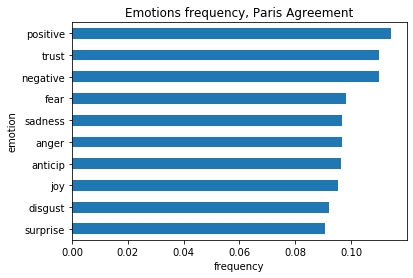

In [91]:
emotion_freq.set_index("emotion").plot.barh(legend = False)
plt.title("Emotions frequency, Paris Agreement")
plt.xlabel("frequency")
plt.ylabel("emotion")
plt.show()

In [71]:
nrc.top_emotions

[('positive', 0.11421679909194098)]

#### Sentiment Analysis with Vader

In [4]:
sa = SentimentIntensityAnalyzer()
sa_results = {tweet:sa.polarity_scores(tweet) for tweet in list(tweets)}
sa_avgs = {val:np.mean([sent[val] for sent in sa_results.values()]) for val in ["neg", "neu", "pos"]}

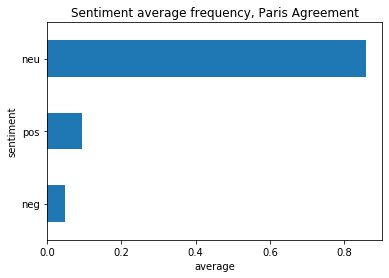

In [5]:
pos_neg_avg = pd.DataFrame(sa_avgs.items(), columns = ["sentiment", "frequency"]).sort_values(by = "frequency")
pos_neg_avg.set_index("sentiment").plot.barh(legend = False)
plt.title("Sentiment average frequency, Paris Agreement")
plt.xlabel("average")
plt.ylabel("sentiment")
plt.show()

In [6]:
display(pos_neg_avg)

,sentiment,frequency
0,neg,0.048637
2,pos,0.093460
1,neu,0.857901


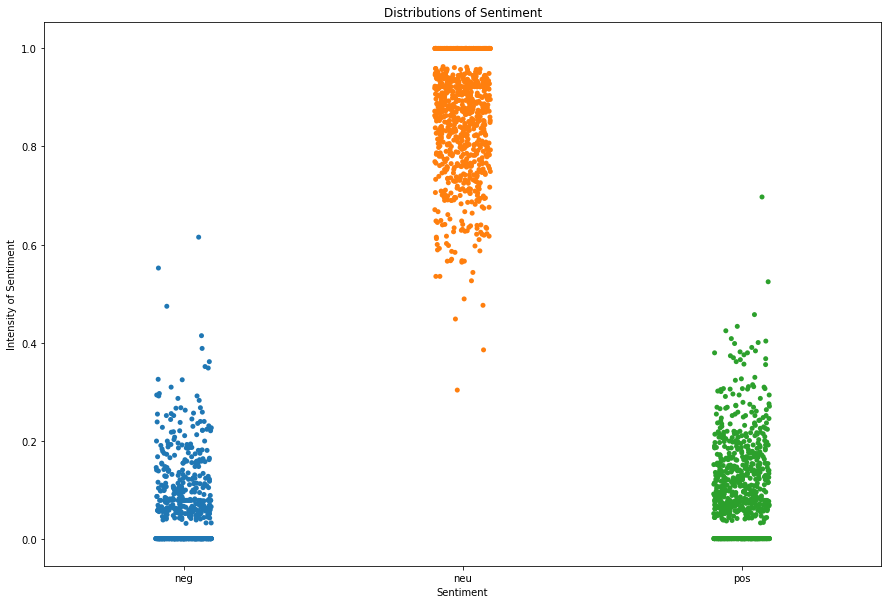

In [8]:
plt.figure(figsize=(15,10))
strp = {val:[sent[val] for sent in sa_results.values()] for val in ["neg", "neu", "pos"]}
strp = pd.DataFrame.from_dict(strp)
sns.stripplot(data = strp)
plt.title("Distributions of Sentiment")
plt.ylabel("Intensity of Sentiment")
plt.xlabel("Sentiment")
plt.show()

#### Sentiment Analysis by Topic
*I'm not very confident about the validity of this since there aren't sentences*

In [129]:
topics = []
for idx, topic in enumerate(lda.components_):
    topics.append([count_vectorizer.get_feature_names()[i] for i in topic.argsort()[:-len(topic) - 1:-1]])

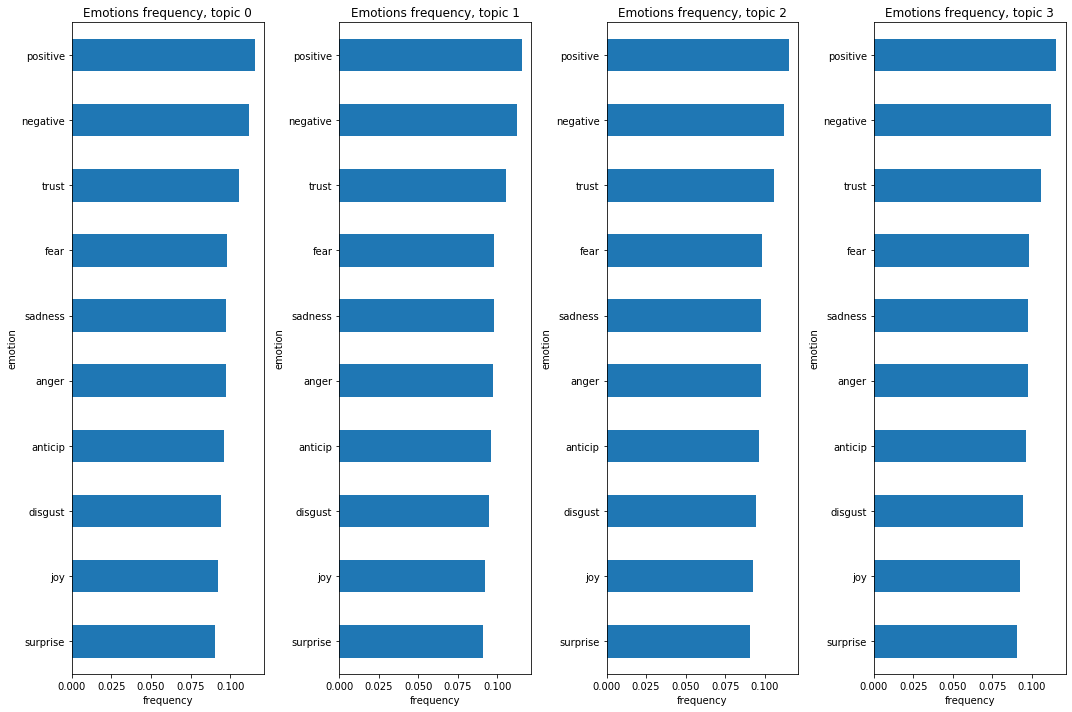

In [146]:
fig, ax = plt.subplots(1,len(topics), figsize = (15, 10))
for i in range(len(topics)):
    nrc = NRCLex(" ".join(topics[i]))
    emotion_freq = pd.DataFrame(nrc.affect_frequencies.items(), columns = ["emotion", "frequency"]).sort_values(by = "frequency").set_index("emotion")
    emotion_freq.plot.barh(ax = ax[i], legend = False)
    ax[i].set_title("Emotions frequency, topic {}".format(str(i)))
    ax[i].set_xlabel("frequency")
    ax[i].set_ylabel("emotion")
    plt.tight_layout()